## Data

### Download

In [8]:
import gdown
import os
import zipfile

In [9]:
url = "https://drive.google.com/drive/folders/1PTA24UTZcsnzXPN1gmV0_lRg3lMHqwp6"
gdown.download_folder(url, quiet=False, use_cookies=False)

Retrieving folder list


Processing file 1AkJP4E7Wki5miKd6DW8JlW8xf6UfU1ud List.zip
Processing file 1IFDF7gyjnnyrns4Fm-Ui8sMloBsNY1EO Logo-2K+.zip
Processing file 1AnQh1-Ph7gHgw0e1afZVUwfsC5LRK4mb readme.txt
Processing file 1_WeyUnOig7QAkVtzbURG6J6si1k1QYHv train_and_test.zip
Building directory structure completed


Retrieving folder list completed
Building directory structure
Downloading...
From: https://drive.google.com/uc?id=1AkJP4E7Wki5miKd6DW8JlW8xf6UfU1ud
To: /home/yunho/Documents/CV/logo_similarity/Logo-2k+/List.zip
100%|██████████| 908k/908k [00:00<00:00, 6.06MB/s]
Downloading...
From (uriginal): https://drive.google.com/uc?id=1IFDF7gyjnnyrns4Fm-Ui8sMloBsNY1EO
From (redirected): https://drive.google.com/uc?id=1IFDF7gyjnnyrns4Fm-Ui8sMloBsNY1EO&confirm=t&uuid=f0b75145-966a-45e3-9228-99fa6d336247
To: /home/yunho/Documents/CV/logo_similarity/Logo-2k+/Logo-2K+.zip
100%|██████████| 1.57G/1.57G [01:00<00:00, 26.1MB/s]
Downloading...
From: https://drive.google.com/uc?id=1AnQh1-Ph7gHgw0e1afZVUwfsC5LRK4mb
To: /home/yunho/Documents/CV/logo_similarity/Logo-2k+/readme.txt
100%|██████████| 1.71k/1.71k [00:00<00:00, 7.60MB/s]
Downloading...
From (uriginal): https://drive.google.com/uc?id=1_WeyUnOig7QAkVtzbURG6J6si1k1QYHv
From (redirected): https://drive.google.com/uc?id=1_WeyUnOig7QAkVtzbURG6J6si1k1QYHv&

['/home/yunho/Documents/CV/logo_similarity/Logo-2k+/List.zip',
 '/home/yunho/Documents/CV/logo_similarity/Logo-2k+/Logo-2K+.zip',
 '/home/yunho/Documents/CV/logo_similarity/Logo-2k+/readme.txt',
 '/home/yunho/Documents/CV/logo_similarity/Logo-2k+/train_and_test.zip']

In [10]:
dir_name = os.getcwd() + "/Logo-2k+"
new_dir_name = os.getcwd() + "/Data"

os.rename(dir_name, new_dir_name)

In [11]:
for filename in os.listdir(new_dir_name):
    if filename.endswith(".zip"):
        filepath = os.path.join(new_dir_name, filename)
        with zipfile.ZipFile(filepath, 'r') as zipObj:
            zipObj.extractall(new_dir_name)

### Loader

In [1]:
import torch
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
import torchvision.utils as utils
from torchvision.datasets import ImageFolder
from PIL import Image

import matplotlib.pyplot as plt
import os

In [2]:
INPUT_SIZE = (448, 448) 

transform = transforms.Compose([
    transforms.Resize((600, 600), Image.BILINEAR),
    transforms.RandomCrop(INPUT_SIZE),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.485, 0.456, 0.406),
                                 std=(0.229, 0.224, 0.225))
    ])

### Custom Loader(from original code)

In [ ]:
class GetLoader(Dataset):
    def __init__(self, data_root, data_list, transform=None):
        self.transform = transform
        self.data_root = data_root
        f = open(data_list, 'r')
        data_list = f.readlines()
        f.close()

        self.n_data = len(data_list)

        self.img_paths = []
        self.labels = []

        for data in data_list:
            image_path = data[:-1]
            label = image_path.split('/')[1]
            self.img_paths.append(image_path)
            self.labels.append(label)

    def __getitem__(self, item):
        img_path, label= self.img_paths[item], self.labels[item]
        # img_path_full = os.path.join(self.data_root, img_path)
        img_path_full = self.data_root+img_path
        img = Image.open(img_path_full).convert('RGB')
        # label = np.array(label,dtype='float32')
        label = int(label)-100
        if self.transform is not None:
            img = self.transform(img)

        return img, label

    def __len__(self):
        return self.n_data

In [14]:
train_dataset = GetLoader(data_root = os.getcwd()+'/Data/Logo-2k+/', 
                        data_list = os.getcwd()+'/Data/List/train_images_root.txt',
                        transform = transform)

test_dataset = GetLoader(data_root = os.getcwd()+'/Data/Logo-2k/', 
                        data_list = os.getcwd()+'/Data/List/test_images_root.txt',
                        transform = transform)

In [15]:
print(len(train_dataset))
print(len(test_dataset))

116958
50182


### ImageFolder

In [3]:
train_imgfolder = ImageFolder(root = os.getcwd()+'/Data/train_and_test/train/',
                            transform = transform,
                            target_transform = None)

test_imgfolder = ImageFolder(root = os.getcwd()+'/Data/train_and_test/test/',
                             transform = transform)

In [4]:
print(train_imgfolder.classes)
print(train_imgfolder.class_to_idx)

['Accessories', 'Clothes', 'Cosmetic', 'Electronic', 'Food', 'Institution', 'Leisure', 'Medical', 'Necessities', 'Transportation']
{'Accessories': 0, 'Clothes': 1, 'Cosmetic': 2, 'Electronic': 3, 'Food': 4, 'Institution': 5, 'Leisure': 6, 'Medical': 7, 'Necessities': 8, 'Transportation': 9}


In [5]:
print(len(train_imgfolder.imgs))
print(len(test_imgfolder.imgs))

116958
50182


In [6]:
train_imgloader = DataLoader(dataset = train_imgfolder,
                            batch_size = 32,
                            num_workers = 2,
                            shuffle = True)

train_imgloader = DataLoader(dataset = train_imgfolder,
                            batch_size = 32,
                            num_workers = 2,
                            shuffle = False)

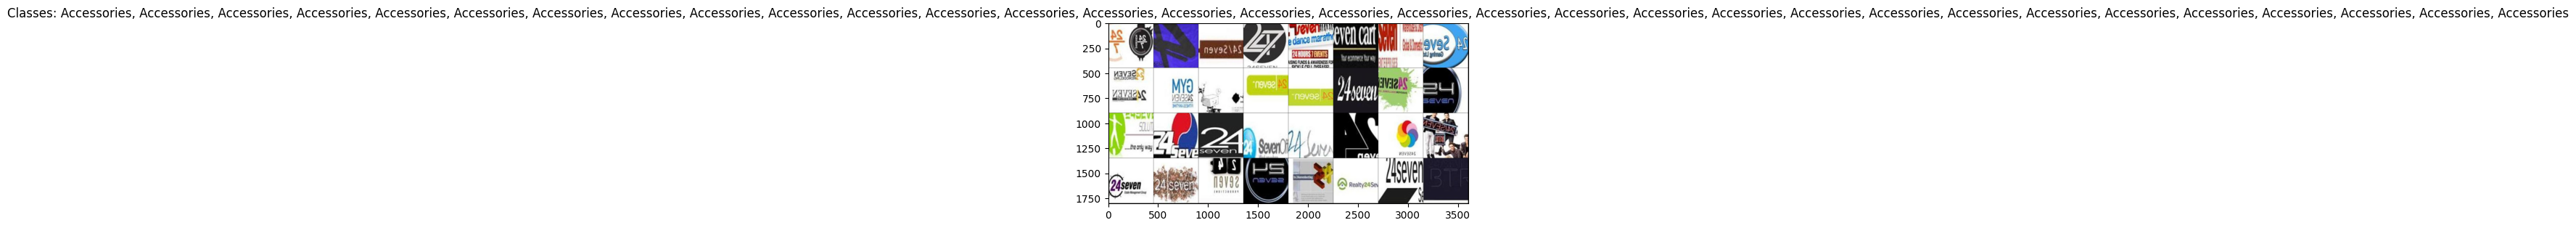

In [7]:
# Function to denormalize and bring back the image to original form
def denormalize(tensor):
    mean = torch.Tensor((0.485, 0.456, 0.406)).view(3, 1, 1)
    std = torch.Tensor((0.229, 0.224, 0.225)).view(3, 1, 1)
    return tensor * std + mean

# Get a batch of training data
inputs, classes = next(iter(train_imgloader))

# Make a grid from batch
inputs = denormalize(inputs)
out = utils.make_grid(inputs)

plt.imshow(out.numpy().transpose((1, 2, 0)))
plt.title('Classes: '+ ', '.join('%5s' % train_imgfolder.classes[classes[j]] for j in range(len(classes))))
plt.show()

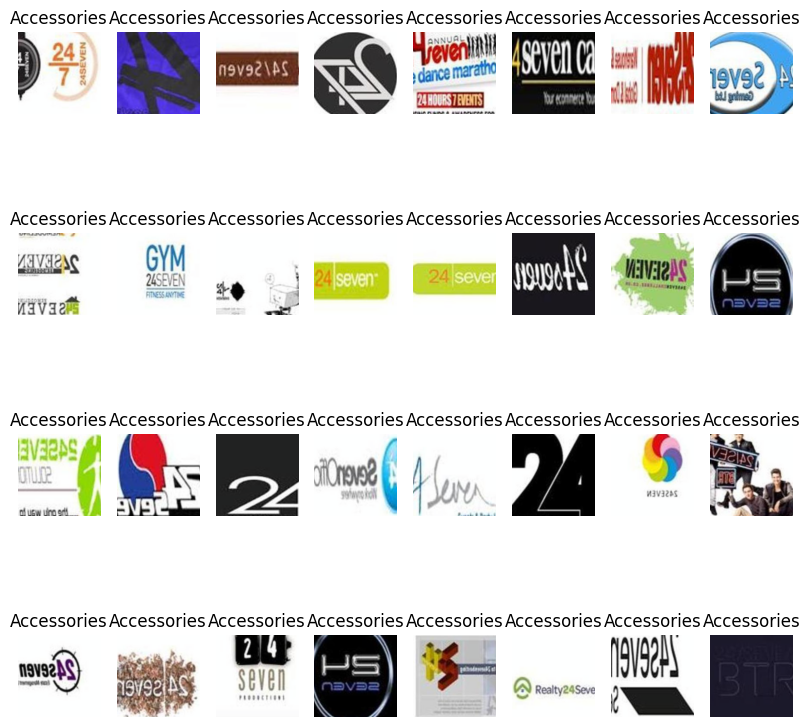

In [12]:
import matplotlib.pyplot as plt
import numpy as np
import torchvision

def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)

# Get a batch of training data
inputs, classes = next(iter(train_imgloader))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

# Denormalize images and plot
fig = plt.figure(figsize=(10,10))

for i in range(len(inputs)):
    fig.add_subplot(4, 8, i+1)
    imshow(inputs[i])
    plt.title(train_imgfolder.classes[classes[i]])
    plt.axis('off')

plt.show()


## Model

In [ ]:
from transformers import AutoFeatureExtractor, AutoModel

model_ckpt = "google/vit-base-patch16-224-in21k"
extractor = AutoFeatureExtractor.from_pretrained(model_ckpt)
model = AutoModel.from_pretrained(model_ckpt)

# Pipeline

## Model

- Vision Transformer(ViT) base 모델 사용
- Alternative) Swin Transformer, ConvNeXT, RegNet 모델

In [ ]:
from transformers import AutoFeatureExtractor, AutoModel

model_ckpt = "nateraw/vit-base-beans"
extractor = AutoFeatureExtractor.from_pretrained(model_ckpt) # extractor: pret_trained model feature 추출기
model = AutoModel.from_pretrained(model_ckpt) # model: feature 추출기를 통해 추출된 feature를 입력받아 output을 반환하는 모델

/home/yunho/anaconda3/envs/logo/lib/python3.8/site-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(
Some weights of the model checkpoint at nateraw/vit-base-beans were not used when initializing ViTModel: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing ViTModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ViTModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ViTModel were not initialized from the model checkpoint at nateraw/vit-base-beans and are newly initialized: 

In [ ]:
model

ViTModel(
  (embeddings): ViTEmbeddings(
    (patch_embeddings): ViTPatchEmbeddings(
      (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    )
    (dropout): Dropout(p=0.0, inplace=False)
  )
  (encoder): ViTEncoder(
    (layer): ModuleList(
      (0-11): 12 x ViTLayer(
        (attention): ViTAttention(
          (attention): ViTSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.0, inplace=False)
          )
          (output): ViTSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.0, inplace=False)
          )
        )
        (intermediate): ViTIntermediate(
          (dense): Linear(in_features=768, out_features=3072, bias=True)
          (intermediate_act_fn): GELUActivation(

In [ ]:
model.config

ViTConfig {
  "_name_or_path": "nateraw/vit-base-beans",
  "architectures": [
    "ViTForImageClassification"
  ],
  "attention_probs_dropout_prob": 0.0,
  "encoder_stride": 16,
  "finetuning_task": "image-classification",
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 768,
  "id2label": {
    "0": "angular_leaf_spot",
    "1": "bean_rust",
    "2": "healthy"
  },
  "image_size": 224,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "angular_leaf_spot": "0",
    "bean_rust": "1",
    "healthy": "2"
  },
  "layer_norm_eps": 1e-12,
  "model_type": "vit",
  "num_attention_heads": 12,
  "num_channels": 3,
  "num_hidden_layers": 12,
  "patch_size": 16,
  "qkv_bias": true,
  "torch_dtype": "float32",
  "transformers_version": "4.29.2"
}

In [ ]:
hidden_dim = model.config.hidden_size # 768

In [ ]:
extractor.size["height"], extractor.size["width"] # 224, 224

(224, 224)

In [ ]:
import torchvision.transforms as T

transformation_chain = T.Compose(
    [
        T.Resize(int((256 / 224) * extractor.size["height"])), # 256x256으로 resize
        T.CenterCrop(extractor.size["height"]), # 224x224로 center crop
        T.ToTensor(),
        T.Normalize(mean=extractor.image_mean, std=extractor.image_std),
    ]
)

In [ ]:
import torch

# 이미지를 입력받아 feature를 반환하는 함수
def extract_embeddings(model: torch.nn.Module):
    """Utility to compute embeddings."""
    device = model.device

    def pp(batch):
        images = batch["image"]
        image_batch_transformed = torch.stack(
            [transformation_chain(image) for image in images]
        )
        new_batch = {"pixel_values": image_batch_transformed.to(device)}
        with torch.no_grad(): # gradient 계산 안함(training이 아니므로)
            embeddings = model(**new_batch).last_hidden_state[:, 0].cpu() # model에 이미지를 입력받아 feature를 반환
        return {"embeddings": embeddings} # feature 반환

    return pp

In [ ]:
batch_size = 32
device = "cuda" if torch.cuda.is_available() else "cpu"
extract_fn = extract_embeddings(model.to(device)) # model에 이미지를 입력받아 feature를 반환하는 함수
candidate_subset_emb = candidate_subset.map(extract_fn, batched=True, batch_size=batch_size)

In [ ]:
from tqdm.auto import tqdm

candidate_ids = []

for id in tqdm(range(len(candidate_subset_emb))):
    label = candidate_subset_emb[id]["labels"]
    
    entry = str(id) + "_" + str(label)

    candidate_ids.append(entry) # id와 label을 합쳐서 candidate_ids에 저장

100%|██████████| 1000/1000 [00:02<00:00, 369.40it/s]


In [ ]:
import numpy as np

all_candidate_embeddings = np.array(candidate_subset_emb["embeddings"]) # feature를 numpy array로 변환
all_candidate_embeddings = torch.from_numpy(all_candidate_embeddings) # numpy array를 torch tensor로 변환

In [ ]:
def compute_scores(emb_one, emb_two):
    scores = torch.nn.functional.cosine_similarity(emb_one, emb_two)
    return scores.numpy().tolist()


def fetch_similar(image, top_k=5):
    # 이미지 전처리
    image_transformed = transformation_chain(image).unsqueeze(0)
    new_batch = {"pixel_values": image_transformed.to(device)}

    # 이미지에 대한 embedding 추출
    with torch.no_grad():
        query_embeddings = model(**new_batch).last_hidden_state[:, 0].cpu()

    # 이미지와 가장 유사한 이미지를 찾기 위해 코사인 유사도 계산
    sim_scores = compute_scores(all_candidate_embeddings, query_embeddings)
    similarity_mapping = dict(zip(candidate_ids, sim_scores))
 
    # 코사인 유사도가 높은 순으로 정렬
    similarity_mapping_sorted = dict(
        sorted(similarity_mapping.items(), key=lambda x: x[1], reverse=True)
    )
    id_entries = list(similarity_mapping_sorted.keys())[:top_k]

    ids = list(map(lambda x: int(x.split("_")[0]), id_entries))
    labels = list(map(lambda x: int(x.split("_")[-1]), id_entries))
    return ids, labels

In [ ]:
test_idx = np.random.choice(len(dataset["test"])) # test set에서 랜덤하게 샘플을 선택
test_sample = dataset["test"][test_idx]["image"] # 선택된 샘플의 이미지
test_label = dataset["test"][test_idx]["labels"] # 선택된 샘플의 라벨

sim_ids, sim_labels = fetch_similar(test_sample) # 선택된 샘플과 유사한 샘플을 찾아 id와 label을 반환
print(f"Query label: {test_label}")
print(f"Top 5 candidate labels: {sim_labels}")

Query label: 1
Top 5 candidate labels: [1, 1, 1, 1, 1]


In [ ]:
label2id, id2label = dict(), dict() # label을 id로 변환하는 딕셔너리

for i, label in enumerate(labels):
    label2id[label] = i # label을 id로 변환
    id2label[i] = label # id를 label로 변환

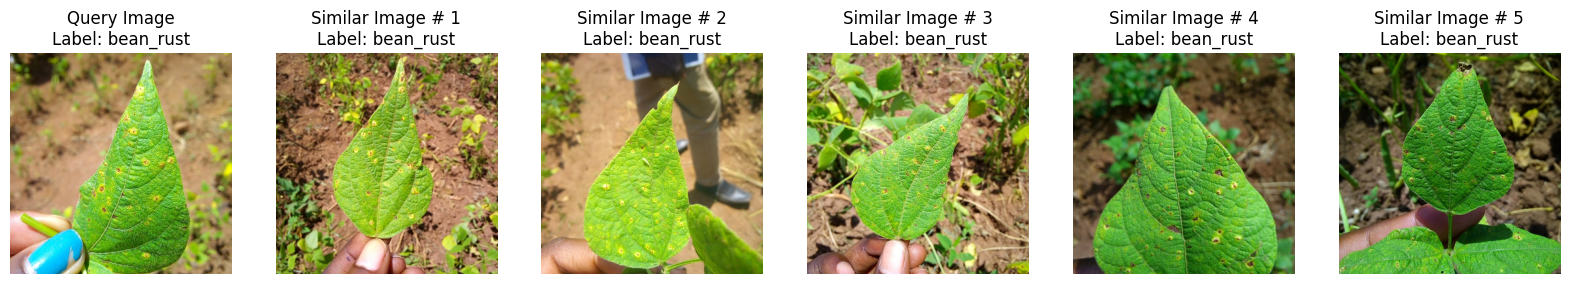

In [ ]:
import matplotlib.pyplot as plt
import math


def plot_images(images, labels):
    if not isinstance(labels, list):
        labels = labels.tolist()

    plt.figure(figsize=(20, 10))
    columns = 6
    for (i, image) in enumerate(images):
        label_id = int(labels[i])
        ax = plt.subplot(math.ceil(len(images) / columns) + 1, columns, i + 1)
        if i == 0:
            ax.set_title("Query Image\n" + "Label: {}".format(id2label[label_id]))
        else:
            ax.set_title(
                "Similar Image # " + str(i) + "\nLabel: {}".format(id2label[label_id])
            )
        plt.imshow(np.array(image).astype("int"))
        plt.axis("off")


images = []
labels = []

for id, label in zip(sim_ids, sim_labels):
    images.append(candidate_subset_emb[id]["image"])
    labels.append(candidate_subset_emb[id]["labels"])

images.insert(0, test_sample)
labels.insert(0, test_label)
plot_images(images, labels)